# 8.1. Loading Dataset

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import h5py
#h5f = h5py.File('/content/drive/My Drive/Projects/Neural Networks/SVHN_single_grey1.h5', 'r')
h5f = h5py.File('SVHN_single_grey1.h5')
#Loading the training & validation data
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_val = h5f['X_test'][:]
y_val = h5f['y_test'][:]

#Close the file
h5f.close()

In [3]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(42000, 32, 32) (42000,) (18000, 32, 32) (18000,)


In [4]:
#reshaping the data to (n, 32x32)
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)
print(X_train.shape, X_val.shape)

(42000, 1024) (18000, 1024)


In [5]:
#Normalizing the inputs from 0 to 255 to 0 to 1
X_train = X_train/255.0
X_val = X_val/255.0

In [9]:
import matplotlib.pyplot as plt

Label: 0


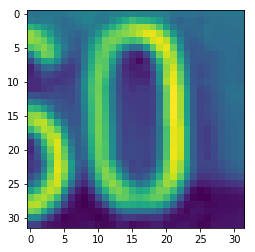

In [0]:
plt.imshow(X_train[3400].reshape(32,32))
print("Label:", y_train[3400])

Label: 1


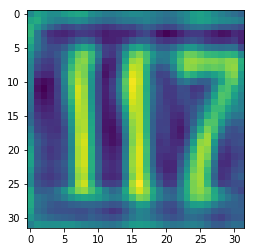

In [0]:
plt.imshow(X_val[3400].reshape(32,32))
print("Label:", y_val[3400])

# 8.2. Applying k-NearestNeighbor Classifier

## 8.2.1. Applying base model

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [0]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
y_pred = KNN.predict(X_val)
accuracy_score(y_val, y_pred)

0.49016666666666664

Base model is predicting with an accuracy of 49% alone which is not a ideal prediction model. Lets tune the parameters to check if there can be a better traditional model.

## 8.2.2. Tuning the parameters to arrive at optimal model

In [0]:
grid_params = {'algorithm' : ['ball_tree', 'kd_tree', 'brute'],'leaf_size' : [10,30,40,50],
               'metric' : ['minkowski','euclidean','manhattan'], 'n_neighbors' : [3,5,7,9,11],
               'weights' : ['uniform', 'distance']}
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [0]:
grid = RandomizedSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, n_jobs = 1, cv = 3)

In [0]:
grid_results = grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 219.3min finished


In [0]:
grid_results.best_score_

0.48964285714285716

In [0]:
grid_results.best_params_

{'weights': 'distance',
 'n_neighbors': 11,
 'metric': 'manhattan',
 'leaf_size': 30,
 'algorithm': 'brute'}

In [0]:
KNN_Optimum = KNeighborsClassifier(n_neighbors = 11, weights = 'distance', metric = 'manhattan',
                                   leaf_size = 30)
KNN_Optimum.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')

In [0]:
preds = KNN_Optimum.predict(X_val)

In [0]:
accuracy_score(y_val, preds)

0.5216111111111111

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.50      0.61      0.55      1814
           1       0.49      0.72      0.58      1828
           2       0.63      0.51      0.56      1803
           3       0.46      0.42      0.43      1719
           4       0.65      0.66      0.65      1812
           5       0.48      0.37      0.42      1768
           6       0.47      0.43      0.45      1832
           7       0.66      0.65      0.65      1808
           8       0.42      0.40      0.41      1812
           9       0.47      0.45      0.46      1804

    accuracy                           0.52     18000
   macro avg       0.52      0.52      0.52     18000
weighted avg       0.52      0.52      0.52     18000



In [0]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_val, preds)

array([[[15088,  1098],
        [  704,  1110]],

       [[14826,  1346],
        [  518,  1310]],

       [[15659,   538],
        [  888,   915]],

       [[15430,   851],
        [ 1005,   714]],

       [[15532,   656],
        [  619,  1193]],

       [[15524,   708],
        [ 1111,   657]],

       [[15272,   896],
        [ 1047,   785]],

       [[15575,   617],
        [  634,  1174]],

       [[15189,   999],
        [ 1084,   728]],

       [[15294,   902],
        [ 1001,   803]]])

By looking at the confusion matrix above, there are about 9000+ true positives. The model is able to predict just above 50% of the test data provided.

Observation: Looks like the optimal model is not working well either. There is not much improvement from the base model. Even though there is slight improvement in accuracy from base model, it won't be enough to deal with the real world data and predictions. Apart from the accuracy levels, this is also computationally expensive in terms of time taken.  This is where Neural Networks can pitch in and help with the predictions better. Let's take a look at the same.

# 8.3. Neural Network Classifier

In [6]:
#Importing the required libraries
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [7]:
# converting y data into categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [8]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(42000, 1024) (42000, 10) (18000, 1024) (18000, 10)


## 8.3.1. Base NN Model

In [0]:
base_model = Sequential()

In [0]:
base_model.add(Dense(50, input_shape = (1024, )))
base_model.add(Activation('relu'))
base_model.add(Dense(50))
base_model.add(Activation('relu'))
base_model.add(Dense(50))
base_model.add(Activation('relu'))
base_model.add(Dense(50))
base_model.add(Activation('relu'))
base_model.add(Dense(10))
base_model.add(Activation('softmax'))

In [0]:
sgd = optimizers.SGD(lr = 0.01)
base_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
base_model.fit(X_train, y_train, batch_size = 2, epochs = 10, verbose = 1)


Epoch 1/10
42000/42000 [==============================] - 89s 2ms/step - loss: 2.1542 - accuracy: 0.1820
Epoch 2/10
42000/42000 [==============================] - 89s 2ms/step - loss: 1.5697 - accuracy: 0.4529
Epoch 3/10
42000/42000 [==============================] - 90s 2ms/step - loss: 1.3849 - accuracy: 0.5362
Epoch 4/10
42000/42000 [==============================] - 94s 2ms/step - loss: 1.2790 - accuracy: 0.5814
Epoch 5/10
42000/42000 [==============================] - 99s 2ms/step - loss: 1.2195 - accuracy: 0.6035
Epoch 6/10
42000/42000 [==============================] - 99s 2ms/step - loss: 1.1744 - accuracy: 0.6207
Epoch 7/10
42000/42000 [==============================] - 101s 2ms/step - loss: 1.1421 - accuracy: 0.6323
Epoch 8/10
42000/42000 [==============================] - 103s 2ms/step - loss: 1.1206 - accuracy: 0.6415
Epoch 9/10
42000/42000 [==============================] - 105s 2ms/step - loss: 1.0975 - accuracy: 0.6533
Epoch 10/10
42000/42000 [==========================

In [0]:
results = base_model.evaluate(X_val, y_val)
print('Loss: ', results[0])
print('Test accuracy: ', results[1])

18000/18000 [==============================] - 2s 93us/step
Loss:  1.0006056825849745
Test accuracy:  0.6855555772781372


Observation: The base model invoked is producing better results (accuracy of 68.56%) than the optimum traditional KNN model (accuracy of 52%). There is scope for improving the NN model further. Let's check further..

## 8.3.2. Batch Normalization

Batch Normalization, one of the methods to prevent the "internal covariance shift" problem, has proven to be highly effective.

Normalize each mini-batch before nonlinearity

In [11]:
BNorm_model = Sequential()

BNorm_model.add(Dense(50, input_shape = (1024, )))
BNorm_model.add(BatchNormalization())                    
BNorm_model.add(Activation('relu'))    
BNorm_model.add(Dense(50))
BNorm_model.add(BatchNormalization())                    
BNorm_model.add(Activation('relu'))    
BNorm_model.add(Dense(50))
BNorm_model.add(BatchNormalization())                    
BNorm_model.add(Activation('relu'))    
BNorm_model.add(Dense(50))
BNorm_model.add(BatchNormalization())                    
BNorm_model.add(Activation('relu'))    
BNorm_model.add(Dense(10))
BNorm_model.add(Activation('softmax'))
    
sgd = optimizers.SGD(lr = 0.001)
BNorm_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
BNorm_model.fit(X_train, y_train, batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
42000/42000 [==============================] - 4s 84us/step - loss: 2.0131 - accuracy: 0.3035
Epoch 2/100
42000/42000 [==============================] - 3s 80us/step - loss: 1.9783 - accuracy: 0.3238
Epoch 3/100
42000/42000 [==============================] - 3s 80us/step - loss: 1.9455 - accuracy: 0.3395
Epoch 4/100
42000/42000 [==============================] - 3s 82us/step - loss: 1.9102 - accuracy: 0.3558
Epoch 5/100
42000/42000 [==============================] - 4s 87us/step - loss: 1.8771 - accuracy: 0.3716
Epoch 6/100
42000/42000 [==============================] - 3s 82us/step - loss: 1.8457 - accuracy: 0.3888
Epoch 7/100
42000/42000 [==============================] - 4s 88us/step - loss: 1.8140 - accuracy: 0.4030
Epoch 8/100
42000/42000 [==============================] - 4s 97us/step - loss: 1.7825 - accuracy: 0.4178
Epoch 9/100
42000/42000 [==============================] - 4s 94us/step - loss: 1.7544 - accuracy: 0.4312
Epoch 10/100
42000/42000 [====================

In [0]:
results = BNorm_model.evaluate(X_val, y_val)
print('Loss: ', results[0])
print('Test accuracy: ', results[1])

18000/18000 [==============================] - 3s 148us/step
Loss:  0.9184820583661397
Test accuracy:  0.7196666598320007


Observation: Defintely there is an improvement in NN peformance from the base model after batch normalization. However, the accuracy level of 72% doesn't seem satisfactory. Let's tune the parameters further to see if there can be a better model.

Let's start with increasing epochs to 1000 & changing the learning rate in separate models..

In [12]:
BNorm_model.fit(X_train, y_train, batch_size = 200, epochs = 1000, verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1000





42000/42000 [==============================] - 9s 209us/step - loss: 2.6079 - acc: 0.1011
Epoch 2/1000
42000/42000 [==============================] - 3s 66us/step - loss: 2.4807 - acc: 0.1158
Epoch 3/1000
42000/42000 [==============================] - 3s 66us/step - loss: 2.4004 - acc: 0.1341
Epoch 4/1000
42000/42000 [==============================] - 3s 67us/step - loss: 2.3422 - acc: 0.1524
Epoch 5/1000
42000/42000 [==============================] - 3s 66us/step - loss: 2.2941 - acc: 0.1674
Epoch 6/1000
42000/42000 [==============================] - 3s 66us/step - loss: 2.2509 - acc: 0.1867
Epoch 7/1000
42000/42000 [==============================] - 3s 67us/step - loss: 2.2135 - acc: 0.2025
Epoch 8/1000
42000/42000 [==============================] - 3s 66us/step - loss: 2.1737 - acc: 0.2199
Epoch 9/1000
42000/42000 [==============================] - 3s 66us/step - loss: 

In [14]:
results = BNorm_model.evaluate(X_val, y_val)
print('Loss: ', results[0])
print('Test accuracy: ', results[1])

18000/18000 [==============================] - 1s 83us/step
Loss:  0.738167873594496
Test accuracy:  0.7932222222222223


## 8.3.3. Changing the learning rate

By changing the epochs to 1000 from 100, accuracy has been improved to 79% from 72% which is a significant improvement. Let's also check the same further by chaning the learning rate.

In [0]:
BNormLr_model = Sequential()

BNormLr_model.add(Dense(50, input_shape = (1024, )))
BNormLr_model.add(BatchNormalization())                    
BNormLr_model.add(Activation('relu'))    
BNormLr_model.add(Dense(50))
BNormLr_model.add(BatchNormalization())                    
BNormLr_model.add(Activation('relu'))    
BNormLr_model.add(Dense(50))
BNormLr_model.add(BatchNormalization())                    
BNormLr_model.add(Activation('relu'))    
BNormLr_model.add(Dense(50))
BNormLr_model.add(BatchNormalization())                    
BNormLr_model.add(Activation('relu'))    
BNormLr_model.add(Dense(10))
BNormLr_model.add(Activation('softmax'))
    
sgd = optimizers.SGD(lr = 0.01) #chaning learning rate to 0.01
BNormLr_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
BNormLr_model.fit(X_train, y_train, batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
42000/42000 [==============================] - 6s 137us/step - loss: 2.3091 - accuracy: 0.1765
Epoch 2/100
42000/42000 [==============================] - 4s 92us/step - loss: 1.8908 - accuracy: 0.3559
Epoch 3/100
42000/42000 [==============================] - 4s 89us/step - loss: 1.6093 - accuracy: 0.4860
Epoch 4/100
42000/42000 [==============================] - 4s 90us/step - loss: 1.4232 - accuracy: 0.5597
Epoch 5/100
42000/42000 [==============================] - 4s 102us/step - loss: 1.2896 - accuracy: 0.6025
Epoch 6/100
42000/42000 [==============================] - 4s 94us/step - loss: 1.1897 - accuracy: 0.6334
Epoch 7/100
42000/42000 [==============================] - 4s 92us/step - loss: 1.1189 - accuracy: 0.6538
Epoch 8/100
42000/42000 [==============================] - 4s 92us/step - loss: 1.0590 - accuracy: 0.6715
Epoch 9/100
42000/42000 [==============================] - 4s 93us/step - loss: 1.0143 - accuracy: 0.6848
Epoch 10/100
42000/42000 [==================

In [0]:
results = BNormLr_model.evaluate(X_val, y_val)
print('Loss: ', results[0])
print('Test accuracy: ', results[1])

18000/18000 [==============================] - 3s 169us/step
Loss:  0.7551069406535891
Test accuracy:  0.7789999842643738


In [16]:
BNormLr_model.fit(X_train, y_train, batch_size = 200, epochs = 1000, verbose = 1)

Epoch 1/1000
42000/42000 [==============================] - 3s 81us/step - loss: 2.3215 - acc: 0.1652
Epoch 2/1000
42000/42000 [==============================] - 3s 62us/step - loss: 1.9344 - acc: 0.3389
Epoch 3/1000
42000/42000 [==============================] - 3s 63us/step - loss: 1.6451 - acc: 0.4797
Epoch 4/1000
42000/42000 [==============================] - 3s 61us/step - loss: 1.4291 - acc: 0.5674
Epoch 5/1000
42000/42000 [==============================] - 3s 63us/step - loss: 1.2751 - acc: 0.6149
Epoch 6/1000
42000/42000 [==============================] - 3s 64us/step - loss: 1.1686 - acc: 0.6460
Epoch 7/1000
42000/42000 [==============================] - 3s 63us/step - loss: 1.0856 - acc: 0.6691
Epoch 8/1000
42000/42000 [==============================] - 3s 62us/step - loss: 1.0268 - acc: 0.6865
Epoch 9/1000
42000/42000 [==============================] - 3s 63us/step - loss: 0.9775 - acc: 0.7013
Epoch 10/1000
42000/42000 [==============================] - 3s 61us/step - loss: 

In [17]:
results = BNormLr_model.evaluate(X_val, y_val)
print('Loss: ', results[0])
print('Test accuracy: ', results[1])

18000/18000 [==============================] - 2s 98us/step
Loss:  1.0369576528469722
Test accuracy:  0.7967222222222222


Observation 1: With the learning rate 0.001 & 1000 epochs, 79.32% accuracy has been achieved.

Observation 2: With the learning rate 0.01 & 1000 epochs, 79.67% accuracy has been achieved.

Even though there is not much change in accuracy, loss function (0.7382) is minimized significantly while training the NN with learning rate 0.001 with 1000 epochs and the same is 1.0369 while training the model with learning rate 0.01 & 1000 epochs.

Hence we can say, the model is better off with ReLu activation, Batch normalization, Learning rate 0.001 & 1000 epochs.


# Final Verdict

Traditional nearest neighbors model took lot of time for computing/predicting the image. Even after taking that much time, model unable to predict accurately beyond 52%. Considering the amount of time needed to train the model and accuracy, problem statement is not fit to be solved by the traditional models.

On the bright side, NN was able to predict the same with improved accuracy by taking fraction of time needed by traditional model. There is still scope for improving the accuracy of the neural network model built.